<a href="https://colab.research.google.com/github/bostankhan6/Image-Segmentation-Unet-DeepLabV3-Segnet/blob/master/Improved_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
import os
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook
from skimage.io import imshow
from skimage.transform import resize

import tensorflow as tf
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, GlobalAveragePooling2D, Multiply
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r /content/drive/My\ Drive/A3-Datasets/MonuSeg /content

## Setting Parameters and Loading Data

In [0]:
"""
Used to patchify the dataset of Semantic Segmentation
Set the directory for the current dataset, be sure to change the parameters.
Give new Dataset Dir, also specify the sub directories.
Patch size and Stride can be changed.
"""
import os
from skimage.io import imread, imsave
from skimage.util.shape import view_as_windows

# Parameters to change.
curr_dataset_dir = "MonuSeg/"
new_dataset_dir = "patched_MonuSeg/"

sub_dirs = ["Training/TissueImages/", "Training/GroundTruth/",
             "Test/TissueImages/", "Test/GroundTruth/"]
patch_size = {'rgb': (256,256, 3), 'grayscale': (256,256)}
stride = {'rgb': (256//2, 256//2, 3), 'grayscale': (256//2, 256//2)}

# Create the new dataset directory
os.makedirs(new_dataset_dir, exist_ok=True)

for sub_dir in sub_dirs:
    new_dir_ = new_dataset_dir + sub_dir
    # Create sub_dir in the new dataset directory
    os.makedirs(new_dir_, exist_ok=True)
    dir_ = curr_dataset_dir + sub_dir
    ids = next(os.walk(dir_))[2]

    for id_ in ids:
        img = imread(dir_ + id_)
        img_type = 'rgb' if img.ndim == 3 else 'grayscale'
        new_imgs = view_as_windows(img, patch_size[img_type], stride[img_type])
        new_imgs = new_imgs.reshape(-1, 256, 256, 3) if img.ndim == 3 else new_imgs.reshape(-1, 256, 256)
        for i, patch in enumerate(new_imgs):
            file_name, extension = id_.split('.')
            new_file_name = file_name + f'-PCH{i}.' + extension
            imsave(new_dir_ + new_file_name, patch)

In [0]:
"""
This function can be used to read the images from the dataset created by the patchify_dataset.py.
Example Usage:
X, y = get_images("ModMonuSeg/Training/", (im_width, im_height))
"""
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [0]:
train_parent_dir = '/content/patched_MonuSeg/Training/'
val_parent_dir = '/content/patched_MonuSeg/Test/'
im_shape = (256,256)
X_train, y_train = get_images(train_parent_dir, im_shape)


No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_test, y_test = get_images(val_parent_dir, im_shape, gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


#### Below code can be used to visualize the images and corresponding masks

Training Set Image

Text(0.5, 1.0, 'Ground Truth')

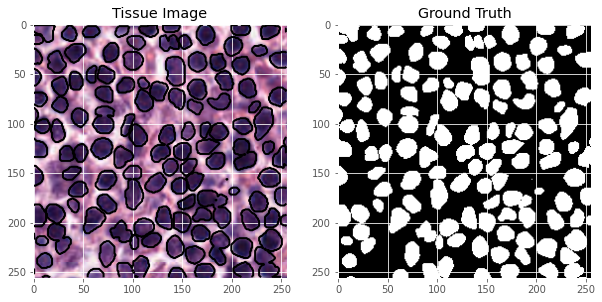

In [0]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))

ax1.imshow(X_train[ix])
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])

ax1.set_title('Tissue Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Ground Truth')

# Defining the model

In [0]:
# This is the squeeze and exception (SE) block that has been added for increasing the validation accuracy 
def se_block(x, ratio=16):
    shape = x.shape.as_list()
    filters = shape[-1]
    z = GlobalAveragePooling2D()(x)
    #s = tf.keras.layers.Dense(filters // ratio, activation='relu', use_bias=False)(z)
    s = Dense(filters, activation='sigmoid', use_bias=False)(z)
    x = Multiply()([x, s])
    return x

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    # In the Unet architecture there are two convolutional layers in this block.
    # It turns out that using a single convolutional layer increases the
    # performance of the network. Therefore only one conv2d layer is used here.
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #SE Block added for improving performance
    x = se_block(x)

    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Define the parametric functions



In [0]:
def dice_coef(y_true, y_pred):
  intersection = K.sum(y_true * y_pred, axis = (1,2,3))
  union = K.sum(y_true, axis = (1,2,3)) + K.sum(y_pred, axis = (1,2,3))
  return K.mean((2.0*intersection+1)/(union+1),axis = 0) 

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Getting the model and compiling

In [0]:
input_img = Input((256, 256, 3))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",dice_coef,f1_m])
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________

In [0]:
# Define the callbacks

callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=6, min_lr=0.000001, verbose=1),
    ModelCheckpoint('improved_unet_model.h5', verbose=1, save_best_only=True, monitor='val_acc')
]

# Training the Model

In [0]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split= 0.1,
                    callbacks=callbacks)
                    #,validation_data=(X_test, y_test))



Train on 972 samples, validate on 108 samples
Epoch 1/100
972/972 [==============================] - 13s 13ms/step - loss: 0.4842 - acc: 0.8257 - dice_coef: 0.5045 - f1_m: 0.7368 - val_loss: 0.4235 - val_acc: 0.8619 - val_dice_coef: 0.4925 - val_f1_m: 0.7101

Epoch 00001: val_acc improved from -inf to 0.86189, saving model to improved_unet_model.h5
Epoch 2/100
972/972 [==============================] - 7s 7ms/step - loss: 0.3604 - acc: 0.8834 - dice_coef: 0.5767 - f1_m: 0.7968 - val_loss: 0.3466 - val_acc: 0.8845 - val_dice_coef: 0.5591 - val_f1_m: 0.7769

Epoch 00002: val_acc improved from 0.86189 to 0.88445, saving model to improved_unet_model.h5
Epoch 3/100
972/972 [==============================] - 7s 7ms/step - loss: 0.2952 - acc: 0.8932 - dice_coef: 0.6364 - f1_m: 0.8100 - val_loss: 0.2801 - val_acc: 0.9005 - val_dice_coef: 0.6343 - val_f1_m: 0.8140

Epoch 00003: val_acc improved from 0.88445 to 0.90046, saving model to improved_unet_model.h5
Epoch 4/100
972/972 [==============

Saving the model and history files to drive

In [0]:
#Copy the best val accuracy model to drive
!cp /content/improved_unet_model.h5 /content/drive/My\ Drive/Models/ACV\ A3\ Models/Improved

In [0]:
#save the history file to drive
import pickle
with open('/content/drive/My Drive/Models/ACV A3 Models/Improved/improved_unet_history', 'wb') as file_pi:
        pickle.dump(results.history, file_pi)

# Plotting the Graphs

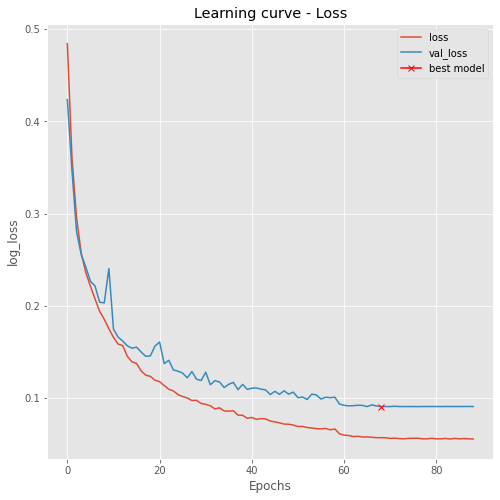

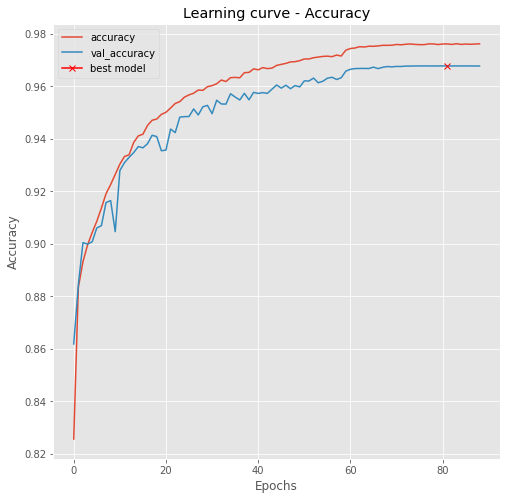

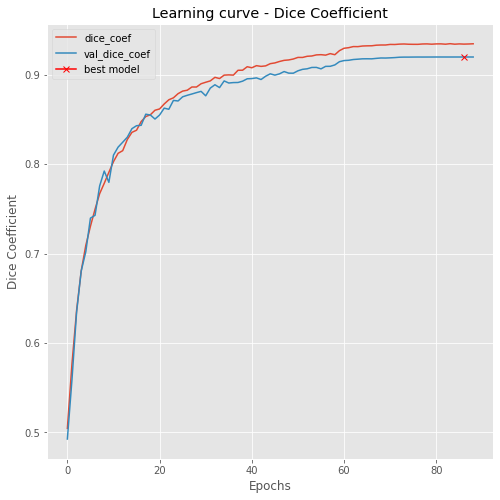

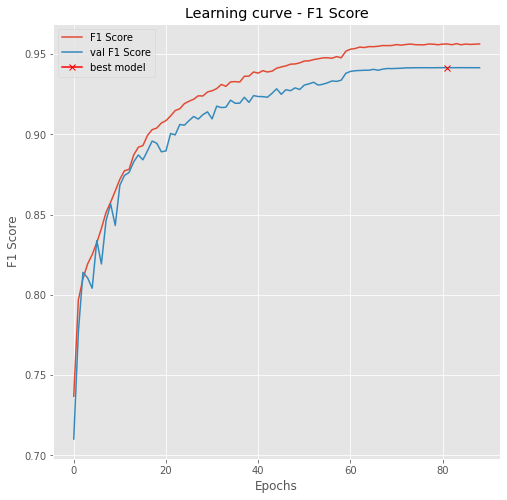

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Accuracy")
plt.plot(results.history["acc"], label="accuracy")
plt.plot(results.history["val_acc"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Dice Coefficient")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - F1 Score")
plt.plot(results.history["f1_m"], label="F1 Score")
plt.plot(results.history["val_f1_m"], label="val F1 Score")
plt.plot( np.argmax(results.history["val_f1_m"]), np.max(results.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend();

### Inference

In [0]:
#evaluate the final model and also save it on the test set
model.save('/content/drive/My Drive/Models/ACV A3 Models/Improved/final_unet_model.h5')
model.evaluate(X_test, y_test, verbose=1)

504/504 [==============================] - 1s 2ms/step


[0.3438292798541841,
 0.9139725830819871,
 0.7727731712280758,
 0.7888988729507204]

In [0]:
 #Loading the best validation accuracy model and evaluating on test set
model_best = load_model('/content/improved_unet_model.h5',
                   custom_objects={"dice_coef": dice_coef,
                                   "f1_m": f1_m
                                   }
                   )
model_best.evaluate(X_test, y_test, verbose=1)

504/504 [==============================] - 3s 5ms/step


[0.34360301541903665,
 0.9140175401218353,
 0.7728260963682144,
 0.7889497724790422]

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, batch_size = 1, verbose=1)
preds_val = model.predict(X_test, batch_size = 1, verbose=1)

504/504 [==============================] - 3s 6ms/step


In [0]:
# Out Thresholds on the the prediction to get either 1 or 0
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)

Helper function for plotting the predictions

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
  #Arguments:
  #X: Train Set
  #y: ground truth Masks
  #preds: the predicted masks
  #binary_preds: the predicted masks after thresholding to 0 or 1
  #ix: if None, it will take a random sample. If provided with the index of the 
  #sample, it will plot that specific sample from tissue images
  
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')
    
    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted binary');

### Visual predictions on training set

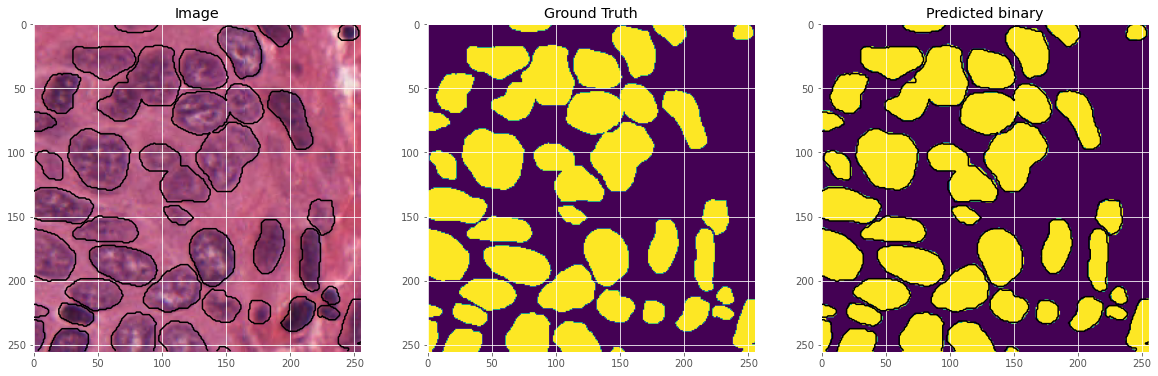

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

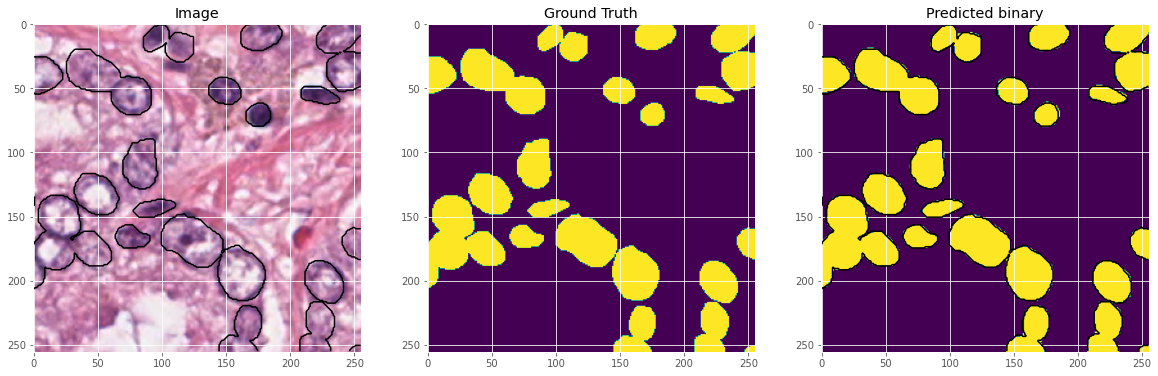

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

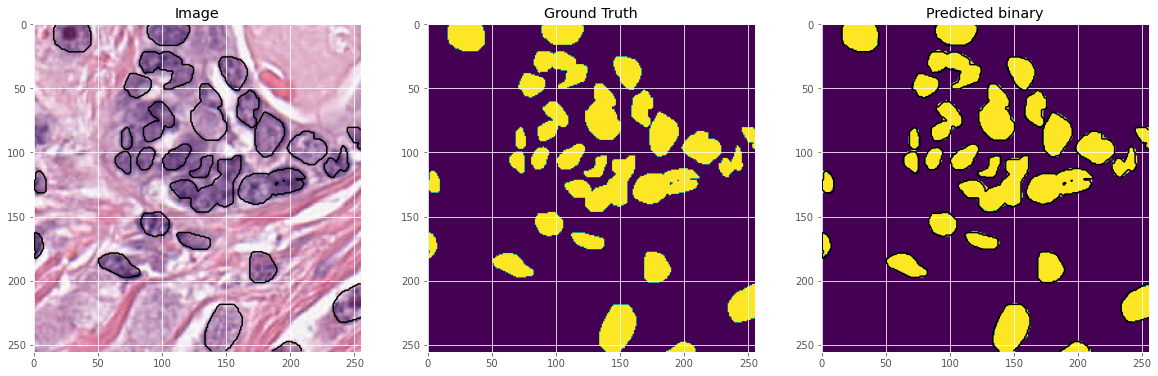

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Visual Predictions on validation set

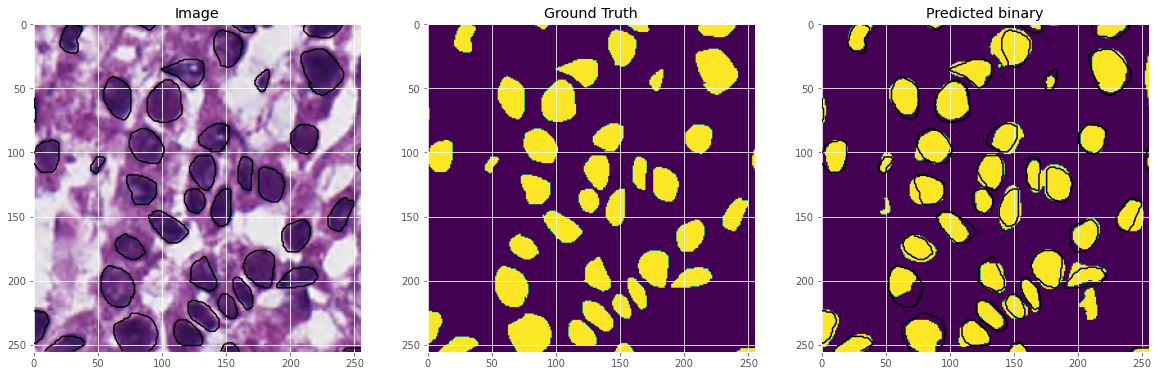

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

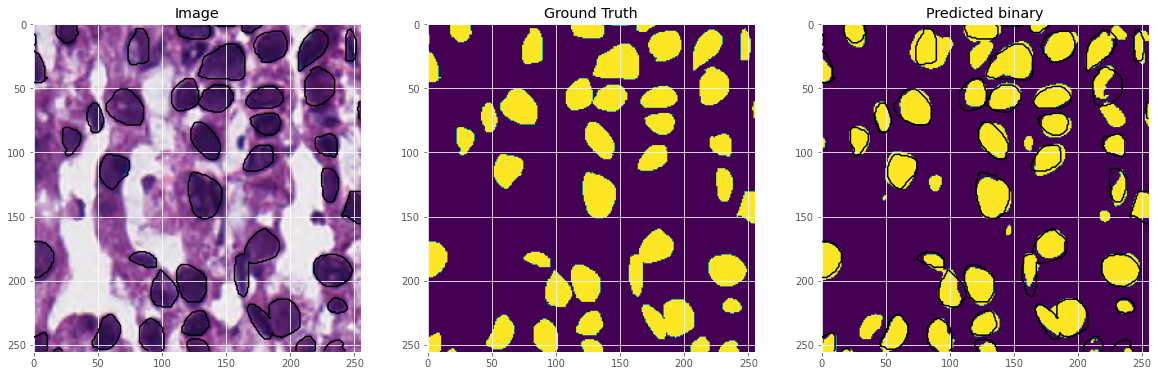

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

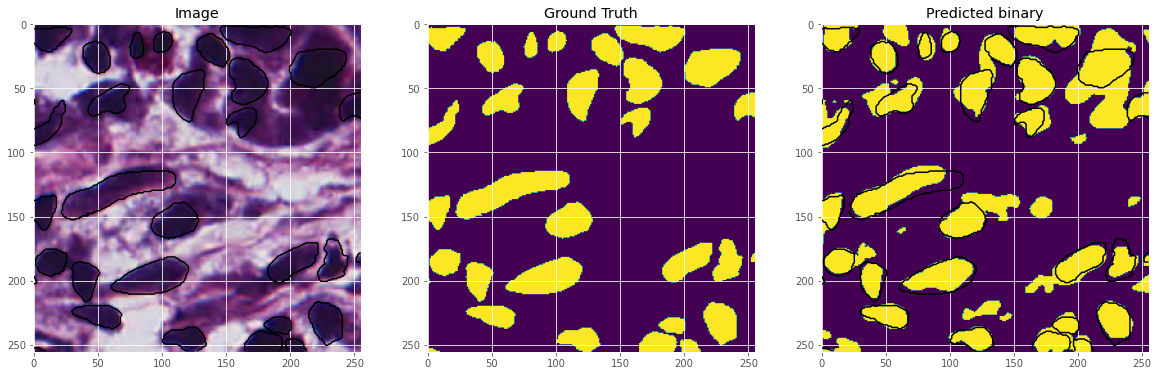

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

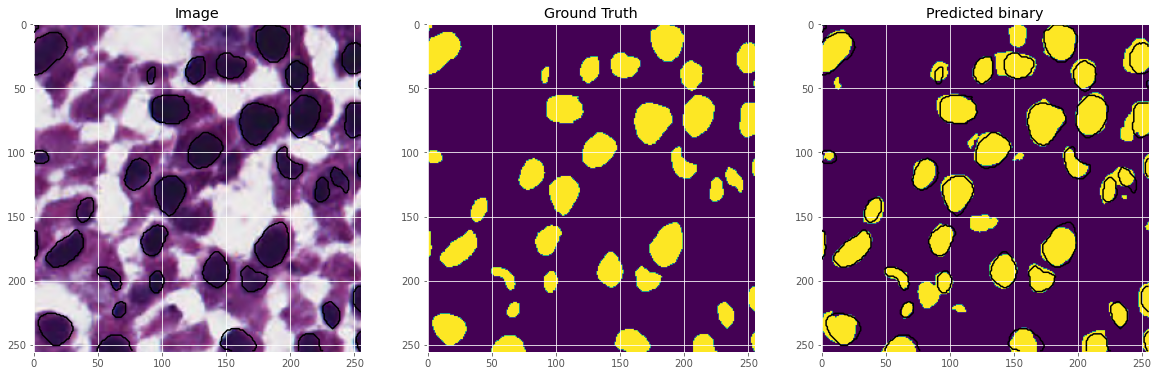

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)